In [1]:
import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import sys, cv2, pickle, math, os
import numpy as np
from numpy import argmax
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from tifffile import imread, imsave
from glob import glob

np.random.seed(109)


import logging
logger = logging.getLogger()  # Logger

logger.setLevel("INFO")
#logging.info("Hello")

In [2]:
def write_pickle(path, obj):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
        
def read_pickle(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

In [3]:
df_dataset = read_pickle(path="/mnt/DataRAID/melismail/Preprocessing/data/pickle_data/SVM/df_combined_incept_6.pkl")

In [4]:
print(df_dataset.head())

             Img         lbl  \
0  18QH2FGR4_270  non-cancer   
1  18QH2FGR4_324  non-cancer   
2  18QH2FGR4_322  non-cancer   
3  18QH2FGR4_397  non-cancer   
4  18QH2FGR4_436  non-cancer   

                                            Features  
0  [0.17763883, 0.14930727, 0.099433355, 0.046645...  
1  [0.2863244, 0.029040584, 0.13237323, 0.0353634...  
2  [0.25656575, 0.19232213, 0.34882596, 0.2506054...  
3  [0.07404756, 0.05178327, 0.018168312, 0.131144...  
4  [0.10449956, 0.085279934, 0.0015779797, 0.0874...  


In [5]:
X = df_dataset["Features"].to_list()
y = df_dataset["lbl"].to_list()

In [6]:
y_dic = {idx: i for idx, i in enumerate(np.unique(y))}
classes = sorted(y_dic.items(), key=lambda item: item[0])
classes = [i[1] for i in classes]
print(y_dic)
print(classes)

{0: 'Basal', 1: 'Classical_CEACAM', 2: 'Classical_KRT7', 3: 'Classical_REG4', 4: 'Classical_TFF1', 5: 'non-cancer'}
['Basal', 'Classical_CEACAM', 'Classical_KRT7', 'Classical_REG4', 'Classical_TFF1', 'non-cancer']


In [7]:
#y = label_binarize(y, classes=classes)
#n_classes = y.shape[1]

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
n_classes = 6

In [9]:
print(y)

[5 5 5 ... 5 5 0]


non-cancer          2276
Classical_TFF1       211
Classical_CEACAM     122
Classical_KRT7        87
Basal                 83
Classical_REG4         3
Name: lbl, dtype: int64


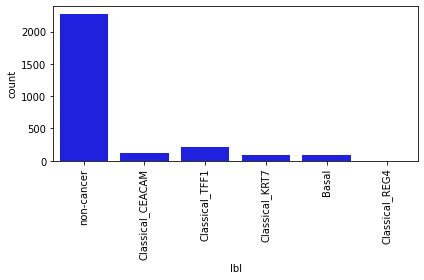

In [10]:
sns.countplot(data=df_dataset, x="lbl", color="blue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('classdistribution_count.png')
print(df_dataset["lbl"].value_counts())

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
#print(f"Training target statistics: {Counter(y_train)}")
#print(f"Testing target statistics: {Counter(y_test)}")

In [12]:
def build_and_test(X_tr, X_te, y_tr, y_te, plot_dir:str, model_name:str, scaler:str='', balancer:str=''):
    print( model_name, scaler, balancer)

    direct = os.path.join(plot_dir, model_name, scaler, balancer) 
    os.makedirs(direct, exist_ok=True)

    #scale data
    if scaler == 'StandardScaler':
        std_scaler = StandardScaler().fit(X_tr + X_te)
        X_tr_scaled = std_scaler.transform(X_tr)
        X_te_scaled = std_scaler.transform(X_te)
    elif scaler == 'MinMaxScaler':
        minmax_scaler = MinMaxScaler().fit(X_tr + X_te)
        X_tr_scaled = minmax_scaler.transform(X_tr)
        X_te_scaled = minmax_scaler.transform(X_te)
    else:
        X_tr_scaled = X_tr
        X_te_scaled = X_te
    
    
    #balance dataset
    if balancer == 'RandomOversampler':
        over_sampler = RandomOverSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = over_sampler.fit_resample(X_tr_scaled, y_tr)
    elif balancer == 'RandomUndersampler':
        under_sampler = RandomUnderSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = under_sampler.fit_resample(X_tr_scaled, y_tr)
    else:
        X_tr_sampled, y_tr_sampled = X_tr_scaled, y_tr
    
    
    #build model
    if model_name == 'SVM_ovo':
        model = OneVsOneClassifier(svm.SVC(kernel='linear', C=1, probability=True))
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'SVM_ovr':
        model = OneVsRestClassifier(svm.SVC(kernel='linear', C=1, probability=True))
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
        y_score = model.predict_proba(X_te)
    elif model_name == 'LogisticRegression_ovo':
        model = OneVsOneClassifier(LogisticRegression(max_iter=1500))
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'LogisticRegression_ovr':
        model = OneVsRestClassifier(LogisticRegression(max_iter=1500))
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
        y_score = model.predict_proba(X_te)
    else:
        print(f'WARNING no {model} model found!')
            
    #print metrices    
    result_dic = {f'Model': model,
                  f'Balancer': balancer,
                  f'Scaler': scaler,
                  f'Precision score': precision_score(y_te, y_pred, average='macro'),
                  f'Recall score':  recall_score(y_te, y_pred, average='macro'),
                  f'F1-score score': f1_score(y_te, y_pred, average='macro'),
                  f'Accuracy score': accuracy_score(y_te, y_pred)}

       
    # Print a classification report
    result_dic['classification_report'] = classification_report(y_te, y_pred)
                
    return result_dic

In [13]:
plot_dir = '/mnt/DataRAID/melismail/Preprocessing/data/Classification/Inception/6class/'
balancer_list = ['RandomOversampler', 'RandomUndersampler', '']
scaler_list = ['MinMaxScaler', 'StandardScaler', '']
ml_model_list = ['SVM_ovr', 'SVM_ovo', 'LogisticRegression_ovo','LogisticRegression_ovr']

classification_dic  = [build_and_test(X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test, plot_dir=plot_dir, model_name = m, scaler=s, balancer=b)
                       for s in scaler_list
                       for b in balancer_list
                       for m in ml_model_list]

SVM_ovr MinMaxScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovo MinMaxScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo MinMaxScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr MinMaxScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovr MinMaxScaler RandomUndersampler
SVM_ovo MinMaxScaler RandomUndersampler
LogisticRegression_ovo MinMaxScaler RandomUndersampler
LogisticRegression_ovr MinMaxScaler RandomUndersampler
SVM_ovr MinMaxScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovo MinMaxScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo MinMaxScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr MinMaxScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovr StandardScaler RandomOversampler
SVM_ovo StandardScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo StandardScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr StandardScaler RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovr StandardScaler RandomUndersampler
SVM_ovo StandardScaler RandomUndersampler
LogisticRegression_ovo StandardScaler RandomUndersampler
LogisticRegression_ovr StandardScaler RandomUndersampler
SVM_ovr StandardScaler 
SVM_ovo StandardScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo StandardScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr StandardScaler 


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovr  RandomOversampler
SVM_ovo  RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo  RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr  RandomOversampler


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovr  RandomUndersampler
SVM_ovo  RandomUndersampler
LogisticRegression_ovo  RandomUndersampler
LogisticRegression_ovr  RandomUndersampler
SVM_ovr  


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM_ovo  


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovo  


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

LogisticRegression_ovr  


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [14]:
def plotting():   
    cm = confusion_matrix(y_te, y_pred)
    
    
    import seaborn as sns
    sns.heatmap(cm)
    plt.show()
    
    plot_confusion_matrix(y_te, y_pred, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(os.path.join(direct, 'Confusion_Matrix.png'))
    plt.clf()
    plt.close()       
 
      
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC curve of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(direct, 'ROC_Curve.png'))
    plt.clf()
    plt.close() 
    
    
    result_dic['macro_roc_auc_ovo'] = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
    result_dic['macro_roc_auc_ovr'] = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")

    

In [15]:
write_pickle(path='/mnt/DataRAID/melismail/Preprocessing/data/Classification/classification_inception_6class.pkl', obj=classification_dic)